<a href="https://colab.research.google.com/github/Orixtosius/RNN_Exercises/blob/main/HousePropertySales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download htagholdings/property-sales

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Input
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

In [ ]:
! unzip property-sales.zip

In [8]:
df_raw_sales = pd.read_csv('raw_sales.csv')

In [112]:
df_raw_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [111]:
df_raw_sales.postcode.unique()

array([2607, 2906, 2905, 2606, 2902, 2612, 2904, 2615, 2914, 2602, 2600,
       2605, 2603, 2611, 2903, 2617, 2913, 2604, 2614, 2912, 2601, 2900,
       2620, 2618, 2616, 2911, 2609])

In [116]:
df_2607 = df_raw_sales[df_raw_sales.postcode == 2607]
df_2607.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
6,2007-04-24 00:00:00,2607,399000,house,3
28,2007-07-30 00:00:00,2607,558000,house,4
32,2007-08-03 00:00:00,2607,520000,house,3
63,2007-09-22 00:00:00,2607,520000,house,4


In [85]:
df_ma_lga = pd.read_csv('ma_lga_12345.csv')
df_ma_lga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   saledate  347 non-null    object
 1   MA        347 non-null    int64 
 2   type      347 non-null    object
 3   bedrooms  347 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.0+ KB


In [ ]:
# R% = ( V_[t] - V_[t-1] ) / V_[t-1]

In [100]:
df_ma_lga['prev_MA'] = df_ma_lga['MA'].shift(1)

In [78]:
df_ma_lga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   saledate  347 non-null    object 
 1   MA        347 non-null    int64  
 2   type      347 non-null    object 
 3   bedrooms  347 non-null    int64  
 4   prev_MA   346 non-null    float64
 5   R         346 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 16.4+ KB


(array([57., 67., 66., 38., 50., 11., 26., 14.,  5., 13.]),
 array([ 316751. ,  386851.1,  456951.2,  527051.3,  597151.4,  667251.5,
         737351.6,  807451.7,  877551.8,  947651.9, 1017752. ]),
 <a list of 10 Patch objects>)

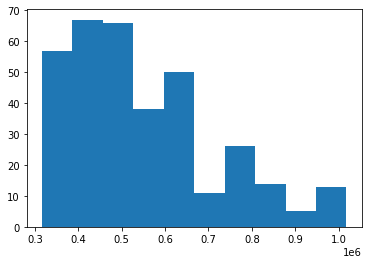

In [29]:
plt.hist(df_ma_lga['MA'])

In [101]:
df_ma_lga['R'] = (df_ma_lga['MA'] - df_ma_lga['prev_MA']) / df_ma_lga['prev_MA']
df_ma_lga.head()

,saledate,MA,type,bedrooms,prev_MA,R
0,30/09/2007,441854,house,2,NaN,NaN
1,31/12/2007,441854,house,2,441854.0,0.000000
2,31/03/2008,441854,house,2,441854.0,0.000000
3,30/06/2008,441854,house,2,441854.0,0.000000
4,30/09/2008,451583,house,2,441854.0,0.022019


(array([  1.,   0.,   0.,   0.,   0.,   1.,   2., 340.,   1.,   1.]),
 array([-0.66393203, -0.57527296, -0.48661389, -0.39795483, -0.30929576,
        -0.22063669, -0.13197763, -0.04331856,  0.04534051,  0.13399958,
         0.22265864]),
 <a list of 10 Patch objects>)

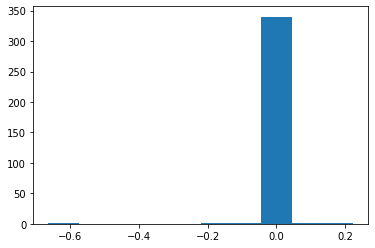

In [30]:
plt.hist(df_ma_lga['R'])

In [102]:
changeInReturn = df_ma_lga['R'].values[1:].reshape(-1,1)
changeInReturn_test = df_ma_lga['R'].values.reshape(1,-1)
#changeInReturn_test2 = df_ma_lga['R'].values.reshape(-1,-1)
print(changeInReturn_test.shape)
#print(changeInReturn_test2.shape)
print(changeInReturn.shape)

(1, 347)
(346, 1)


In [103]:
scaler = StandardScaler()
scaler.fit(changeInReturn[ : len(changeInReturn)//2 ])
changeInReturn_s = scaler.transform(changeInReturn)
changeInReturn_sf = scaler.transform(changeInReturn).flatten()

print(f"Scaled data \n{changeInReturn_s.shape}")
print(f"Scaled and Flatten data \n{changeInReturn_sf.shape}")

Scaled data 
(346, 1)
Scaled and Flatten data 
(346,)


(array([  1.,   0.,   0.,   0.,   0.,   1.,   2., 340.,   1.,   1.]),
 array([-32.84741952, -28.48552152, -24.12362351, -19.76172551,
        -15.3998275 , -11.0379295 ,  -6.67603149,  -2.31413349,
          2.04776452,   6.40966252,  10.77156052]),
 <a list of 10 Patch objects>)

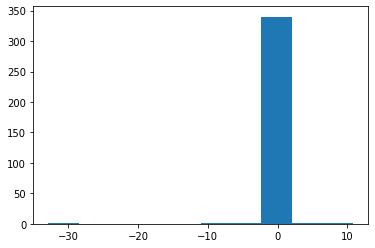

In [40]:
plt.hist(changeInReturn_sf)

In [104]:
N = len(changeInReturn_sf)
D = 1
T = 10
M = 5

In [105]:
X = []
Y = []

for t in range(len(changeInReturn_sf) - T):
  x = changeInReturn[t:t+T]
  X.append(x)
  y = changeInReturn[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,D)
Y = np.array(Y)

print(f'Shape of X is {X.shape} and Shape of Y is {Y.shape}')

Shape of X is (336, 10, 1) and Shape of Y is (336, 1)


In [ ]:
i = Input(shape = (T,D))
lstm = LSTM(M, activation = 'relu')(i)
dense = Dense(1)(lstm)
model = Model(i, dense)
model.compile(loss='mse', optimizer = 'Adam')
r = model.fit(X[:-N//2],Y[:-N//2],validation_data =(X[-N//2:],Y[-N//2:]), epochs = 80)

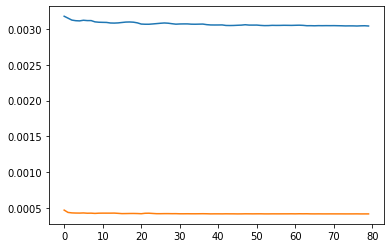

In [107]:
plt.plot(r.history['val_loss'], label='Validation Accuracy')
plt.plot(r.history['loss'], label='Training Accuracy')

In [108]:
prediction_test = X[-1] + np.random.randn(1,10,1)*0.001

In [109]:
prediction_test

array([[[-0.0069059 ],
        [-0.002921  ],
        [ 0.0025882 ],
        [-0.00597797],
        [-0.00043293],
        [-0.00178118],
        [-0.00051828],
        [-0.00389845],
        [ 0.00605476],
        [-0.01118811]]])

In [77]:
model.predict(prediction_test)

array([[0.0023793]], dtype=float32)

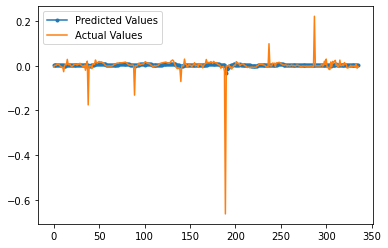

In [81]:
predicted = model.predict(X)

plt.plot(predicted, label = 'Predicted Values', marker = '.')
plt.plot(Y, label = 'Actual Values')
plt.legend()

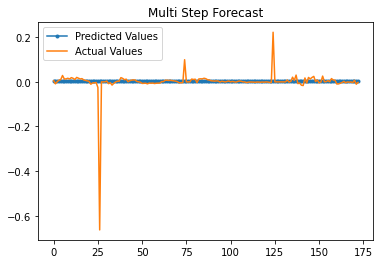

In [110]:
target = Y[-N//2:]
predict = []
X_last = X[-N//2]

while len(target) > len(predict):
  p = model.predict(X_last.reshape(1,T,D))[0,0]
  predict.append(p)
  X_last = np.roll(X_last,-1)
  X_last[-1] = p

plt.title('Multi Step Forecast')
plt.plot(predict, label = 'Predicted Values', marker = '.')
plt.plot(target, label = 'Actual Values')
plt.legend()

USED MA VALUES

In [90]:
MA = df_ma_lga['MA'].values.reshape(-1,1)
scaler.fit(MA[ : len(MA)//2 ])
MA = scaler.transform(MA).flatten()

print(f"Scaled data \n{MA.shape}")

X = []
Y = []

for t in range(len(MA) - T):
  x = MA[t:t+T]
  X.append(x)
  y = MA[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,D)
Y = np.array(Y)

print(f'Shape of X is {X.shape} and Shape of Y is {Y.shape}')

Scaled data 
(347,)
Shape of X is (337, 10, 1) and Shape of Y is (337,)


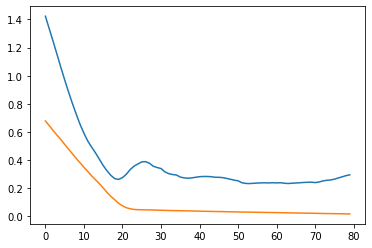

In [92]:
plt.plot(r.history['val_loss'], label='Validation Accuracy')
plt.plot(r.history['loss'], label='Training Accuracy')

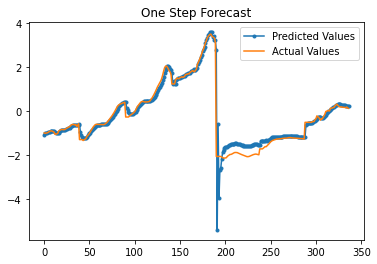

In [94]:
predicted = model.predict(X)

plt.title('One Step Forecast')
plt.plot(predicted, label = 'Predicted Values', marker = '.')
plt.plot(Y, label = 'Actual Values')
plt.legend()

In [96]:
target = Y[-N//2:]
predict = []
X_last = X[-N//2]

while len(target) > len(predict):
  p = model.predict(X_last.reshape(1,T,D))[0,0]
  predict.append(p)
  X_last = np.roll(X_last,-1)
  X_last[-1] = p

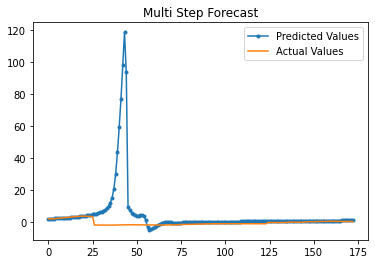

In [97]:
plt.title('Multi Step Forecast')
plt.plot(predict, label = 'Predicted Values', marker = '.')
plt.plot(target, label = 'Actual Values')
plt.legend()